In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime
import fedor_levin_toolkit as fltk
import macro_indicators_toolkit as mitk

# Data load and cleanup

In [108]:
my_list = ['BTC',#Bitcoin
    'DOGE',#Dogecoin
    'LTC', #Litecoin
    'ETH'  #Ethereum
          ]

In [109]:
returns = fltk.crypto_hist_returns_robin(my_list)
returns = returns['2020-11-02':]

In [110]:
returns.head()

,BTC,DOGE,LTC,ETH
Date,,,,
2016-05-13 00:00:00+00:00,0.00764,0.00000,0.01813,0.04804
2016-05-14 00:00:00+00:00,-0.00173,0.00000,0.02036,-0.04116
2016-05-15 00:00:00+00:00,0.00289,0.00000,0.01247,-0.01854
2016-05-16 00:00:00+00:00,-0.00777,0.00000,-0.01232,0.13022
2016-05-17 00:00:00+00:00,0.00057,0.00000,-0.00748,0.07564


In [126]:
returns = returns['2020-11-02':]

In [127]:
#returns = fltk.hist_returns(my_list)
q = int(len(my_list))
er = annualize_rets(returns, 252)
cov = returns.cov()
n = q #number of assets
riskfree_rate = .02

returns = returns.dropna()
returns.head()

,BTC,DOGE,LTC,ETH
Date,,,,
2020-11-02 00:00:00+00:00,-0.01573,-0.02289,-0.02787,-0.03287
2020-11-03 00:00:00+00:00,0.03376,0.00119,0.00380,0.00983
2020-11-04 00:00:00+00:00,0.00926,0.01031,0.01322,0.04140
2020-11-05 00:00:00+00:00,0.10575,0.03612,0.07580,0.03382
2020-11-06 00:00:00+00:00,-0.00244,0.04433,0.07444,0.09068


<AxesSubplot:xlabel='Date'>

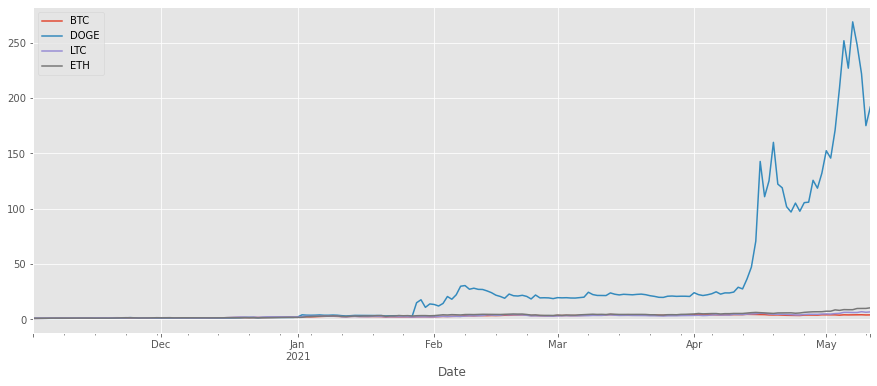

In [150]:
((1+returns['2020-11-02':]).cumprod()).plot(figsize=(15,6)) #returns since 2020-11-02

In [147]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False, show_erc=False):
    """
    Plots the efficient frontier with recommended portfolios
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Efficient frontier": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Efficient frontier", style=style, legend=legend, figsize=(15,6))
    plt.style.use('ggplot')
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10, label='Max Sharpe Ratio')
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10, label='Equal-Weighted')
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add GMV
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10, label='Global Minimum Variance')
    if show_erc:
        w_erc = equal_risk_contributions(cov)
        r_erc = portfolio_return(w_erc, er)
        vol_erc = portfolio_vol(w_erc, cov)
        # add ERC
        ax.plot([vol_erc], [r_erc], color='lime', marker='o', markersize=10, label='Equal Risk Contribution')
        plt.legend(loc='upper left', fontsize=10)
        plt.title('Efficient Frontier')
        
        return ax

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def summary(returns, rf, periods):
    '''
    Returns a DataFrame that contains aggregated summary stats for the returns 
    '''
    
    ann_r = returns.aggregate(annualize_rets, periods_per_year=periods)
    ann_vol = returns.aggregate(annualize_vol, periods_per_year=periods)
    max_dd = returns.min()
    ann_sr = returns.aggregate(sharpe_ratio, riskfree_rate=rf, periods_per_year=periods)
    stat = pd.DataFrame({'Annualized Return': ann_r, 
                         'Annualized Vol': ann_vol, 
                         'Sharpe Ratio': ann_sr, 
                         'Max Drawdown': max_dd})
    return stat

# EW, ERC and GMV

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility'>

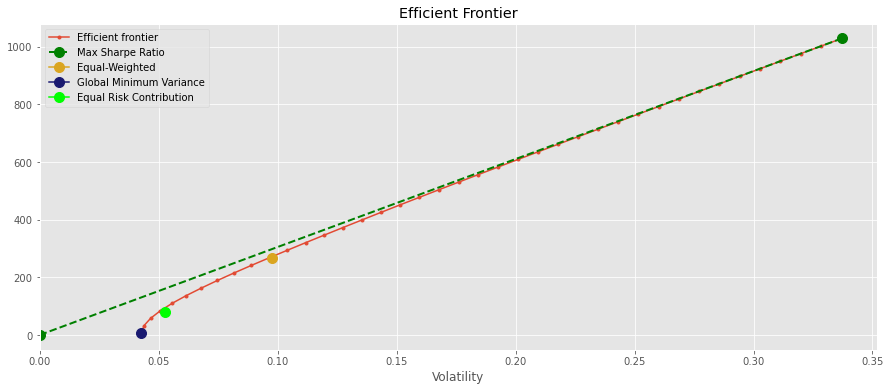

In [148]:
# Equally Weighted %%%%%%%%%%%%%%%%%%%%%%
def ew(n):
    '''
    Returns equal weights for a number of assets
    '''
    w_ew = np.repeat(1/n, n)
    return w_ew
pd.set_option('display.float_format', lambda x: '%.5f' % x)
result_aggressive = pd.DataFrame({'ticker': er.index.to_list(),
                       'weight': ew(n)})


# Equal Risk Contribution %%%%%%%%%%%%%%%%%%%
pd.set_option('display.float_format', lambda x: '%.5f' % x)
result_balanced = pd.DataFrame({'ticker': er.index.to_list(),
                       'weight': equal_risk_contributions(cov)})


# Global Minimum Variance %%%%%%%%%%%%%%%%%%%
pd.set_option('display.float_format', lambda x: '%.5f' % x)
result_conservative = pd.DataFrame({'ticker': er.index.to_list(),
                       'weight': gmv(cov)})


# final 
pd.set_option('display.float_format', lambda x: '%.5f' % x)
final_weights = pd.DataFrame({'ticker': er.index.to_list(), 
                              'EW': ew(n), 
                              'ERC': equal_risk_contributions(cov),
                              'GMV': gmv(cov), 
                              'MSR': msr(riskfree_rate, er, cov)})

# 3 portfolios with MSR
plot_ef(40, er, cov, style='.-', legend=True, show_cml=True, riskfree_rate=riskfree_rate, show_ew=True, show_gmv=True, show_erc=True)

In [131]:
final_weights

,ticker,EW,ERC,GMV,MSR
0,BTC,0.25000,0.37433,0.84213,0.00000
1,DOGE,0.25000,0.06621,0.00000,1.00000
2,LTC,0.25000,0.25833,0.00000,0.00000
3,ETH,0.25000,0.30113,0.15787,0.00000


# Backtesting

<AxesSubplot:xlabel='Date'>

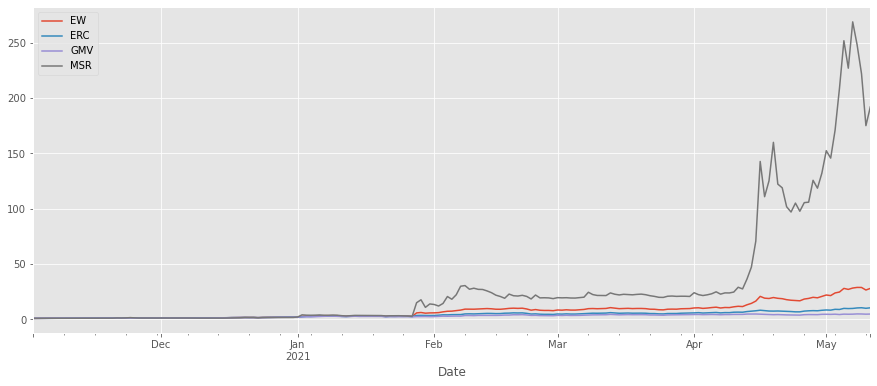

In [149]:
agr=[]
bal=[]
cons=[]
theo=[]
eq_r_w = equal_risk_contributions(cov)
gmv_w = gmv(cov)
msr_w = msr(riskfree_rate, er, cov)
for i in range(len(returns)):
    ret = portfolio_return(ew(n), returns.iloc[i])
    agr.append(ret)
    
for i in range(len(returns)):
    ret = portfolio_return(eq_r_w, returns.iloc[i])
    bal.append(ret)

for i in range(len(returns)):
    ret = portfolio_return(gmv_w, returns.iloc[i])
    cons.append(ret)
    
for i in range(len(returns)):
    ret = portfolio_return(msr_w, returns.iloc[i])
    theo.append(ret)

recom = pd.DataFrame({'EW': agr, 'ERC': bal, 'GMV': cons, 'MSR': theo}, index=returns.index)
((1+recom['2020-11-02':]).cumprod()).plot(figsize=(15,6))

In [135]:
summary(recom['2020-11-02':], rf=riskfree_rate, periods=252)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
EW,80.39235,1.55133,50.80763,-0.14022
ERC,21.29537,0.83385,25.02010,-0.14949
GMV,7.09049,0.67401,10.28621,-0.14371
MSR,1028.29092,5.35077,188.46271,-0.38532


In [136]:
summary(returns['2020-11-02':], rf=riskfree_rate, periods=252)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
BTC,5.47304,0.68224,7.83728,-0.13431
DOGE,1028.29092,5.35077,188.46271,-0.38532
LTC,11.60755,0.99450,11.42519,-0.18297
ETH,21.27597,0.87836,23.73030,-0.19383
